# **A Comparative Analysis of the Performance of Deep Learning Techniques Precision Farming Using Soil and Climate Factors**

1. Assist farmers in crop selection based on soil and climate conditions.
2. Compare the performance of three deep learning models **LSTM, MLP, and ANN** to predict crop yield.
3. Identify which model performs best for precision farming to increase crop yield and reduce resource waste.

The main motivation: Traditional farming methods often rely on guesswork, leading to poor crop yields. Deep learning techniques offer an efficient way to analyze patterns from soil, climate, and past crop yield data

In [1]:
# import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.neural_network import MLPClassifier
from google.colab import files

In [3]:
# import Dataset
df = pd.read_csv("/content/Crop_recommendation.csv")

In [4]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


The dataset, obtained from Kaggle, contains **2200 rows** with **21 crop types**, featuring **soil and climate factors** such as **Nitrogen, Phosphorous, Potassium(K), temperature, humidity, pH, and rainfall**.

# **Preprocessing**

Preprocessing is essential for improving model accuracy, especially with diverse agricultural data. The research paper did not specify the preprocessing techniques used, so we applied key methods to enhance performance. We checked for missing values to avoid biased predictions, detected outliers to remove abnormal data, performed data cleaning and deduplication to ensure dataset consistency, and applied encoding to convert categorical crop labels into numerical format. These steps help provide clean, reliable, and machine-readable data, ultimately supporting better crop predictions and aligning with the research paper's objective of improving precision farming outcomes.

In [5]:
# checking Missing values
missing_summary = df.isnull().sum()
print(missing_summary)

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


There is no missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
Descriptive_stats = df.describe().loc[['mean','50%', 'std']]
Descriptive_stats

,N,P,K,temperature,humidity,ph,rainfall
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389


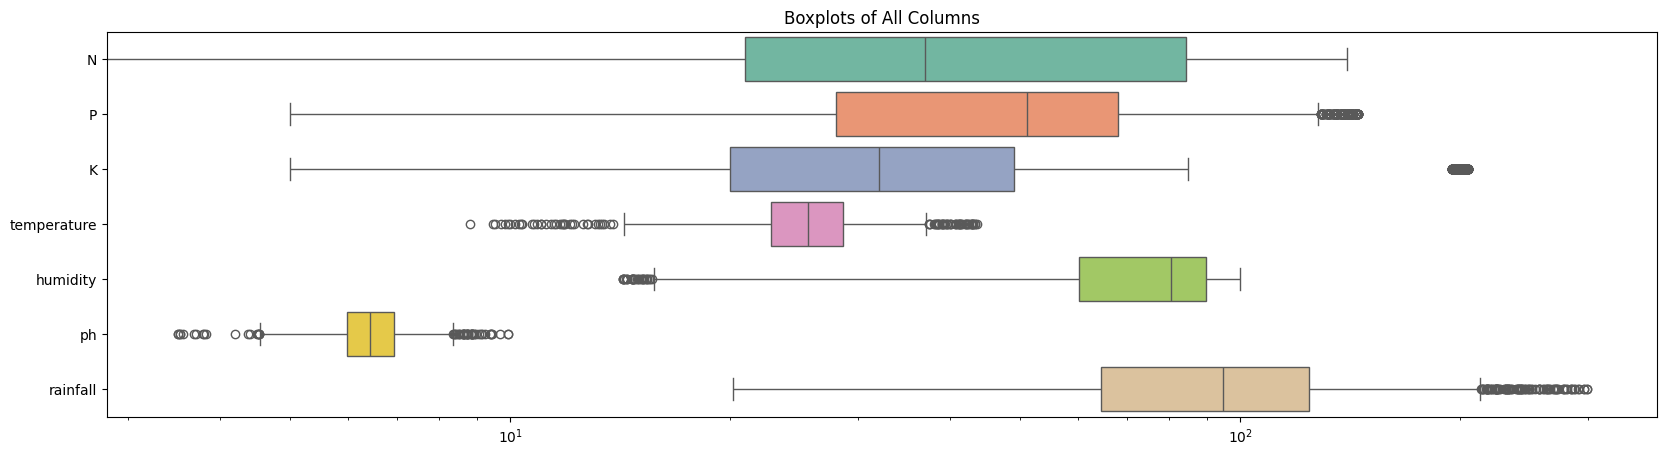

In [8]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df, orient='h', palette='Set2')
plt.xscale('log')
plt.title('Boxplots of All Columns')
plt.show()

Outliers are data points that fall significantly above or below the normal range of values in a dataset. Box plots can be used to visualize these unusual values.

There is more outliers in this dataset and using the Interquartile Range (IQR) method i removed all outliers, because  it is robust, simple, and less affected by extreme values, making it effective for detecting outliers in skewed data.

In [9]:
def remove_outliers(df):
    # Filter only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_data = df[numeric_cols]

    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and remove outliers
    outliers = ((numeric_data < lower_bound) | (numeric_data > upper_bound))

    # Get the indices of the outliers
    outlier_indices = outliers[outliers.any(axis=1)].index

    filtered_df = df[~outliers.any(axis=1)]

    return filtered_df, outlier_indices # Return both the filtered DataFrame and outlier indices

# Call the function and get the filtered DataFrame and outlier indices
cleaned_df, outlier_indices = remove_outliers(df)

In [10]:
cleaned_df = df.drop(outlier_indices)

In [11]:
print("Original DataFrame:")
print(df)
print("\nFiltered DataFrame (without outliers):")
print(cleaned_df)

Original DataFrame:
        N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

Filtered DataFrame (without outliers):
        N   P   K  temperature   humidity        ph

In [12]:
summary_stats = cleaned_df.describe()
print(summary_stats)

                 N            P            K  temperature     humidity  \
count  1768.000000  1768.000000  1768.000000  1768.000000  1768.000000   
mean     54.332014    44.850679    31.715498    25.836913    70.114374   
std      38.436640    22.624973    15.717006     4.168810    21.818135   
min       0.000000     5.000000     5.000000    14.343205    15.755940   
25%      22.000000    25.000000    19.000000    23.411834    58.245751   
50%      40.000000    45.000000    26.000000    25.944613    76.734802   
75%      90.000000    63.000000    44.000000    28.572096    88.165800   
max     140.000000    95.000000    85.000000    37.131650    99.981876   

                ph     rainfall  
count  1768.000000  1768.000000  
mean      6.481933    98.002216  
std       0.681211    48.275844  
min       4.546466    20.211267  
25%       6.026821    59.413838  
50%       6.466501    93.521200  
75%       6.932295   122.063586  
max       8.340398   213.356092  


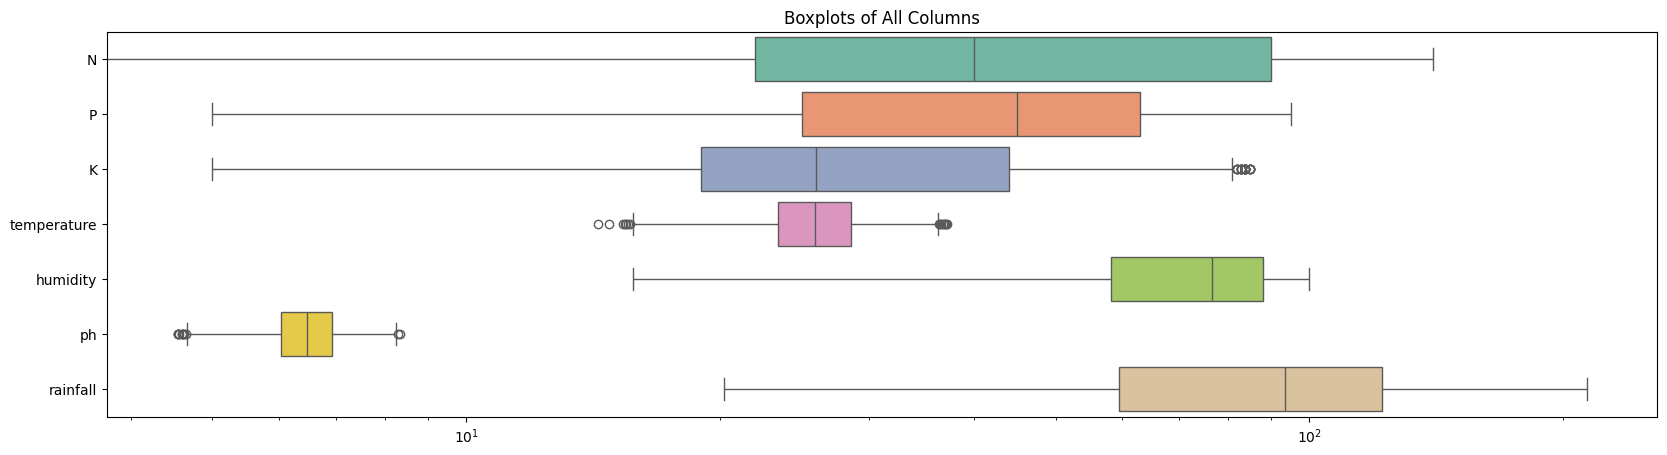

In [13]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=cleaned_df, orient='h', palette='Set2')
plt.xscale('log')
plt.title('Boxplots of All Columns')
plt.show()

**This is after removing outlier plot**

In [14]:
# Data Cleaning and Remove duplicates
cleaned_df.drop_duplicates(inplace=True)

Drops duplicate rows.

In [15]:
cleaned_df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
13,93,56,36,24.014976,82.056872,6.984354,185.277339,rice
14,94,50,37,25.665852,80.663850,6.948020,209.586971,rice
17,91,35,39,23.793920,80.418180,6.970860,206.261186,rice
20,89,45,36,21.325042,80.474764,6.442475,185.497473,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [16]:
# Encode categorical target variable
label_encoder = LabelEncoder()
cleaned_df['label'] = label_encoder.fit_transform(cleaned_df['label'])

Categorical data must be converted to numerical values since algorithms primarily work with numbers. Label encoding assigns unique numerical values to each category in a variable.Converts Lable variable into numerical because for machines only understand numbers, making it easier for models to process and learn patterns.

In [17]:
cleaned_df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,18
13,93,56,36,24.014976,82.056872,6.984354,185.277339,18
14,94,50,37,25.665852,80.663850,6.948020,209.586971,18
17,91,35,39,23.793920,80.418180,6.970860,206.261186,18
20,89,45,36,21.325042,80.474764,6.442475,185.497473,18
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,4
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,4
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,4
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,4


The is the dataset after preprocessed.

# **Explorotary Data Analysis**

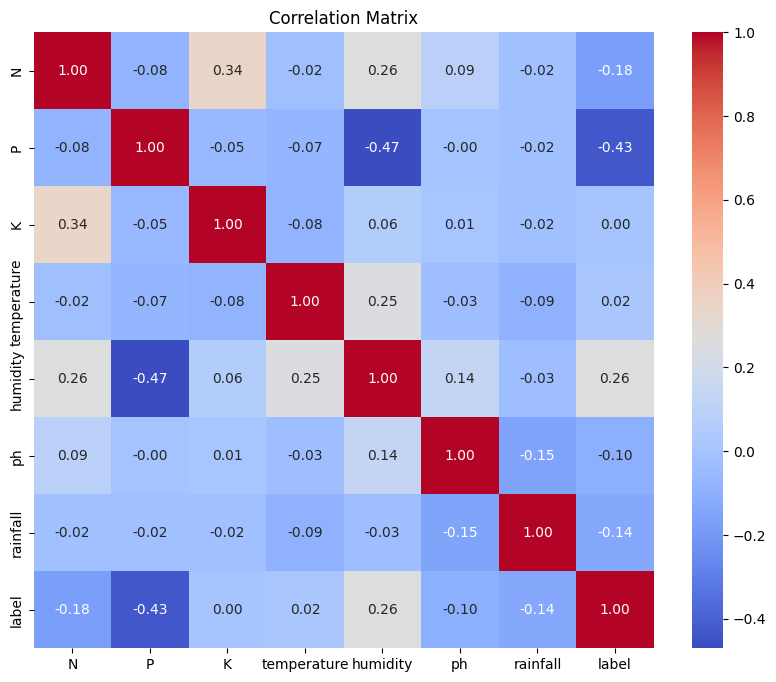

In [18]:
numeric_data = cleaned_df.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

#Let's break down what's happening:

# 1. First, it selects only the numeric columns from a dataframe (cleaned_df)
# 2. Then it calculates correlations between all numeric variables using .corr()
# 3. Creates a visualization using seaborn's heatmap with the following parameters:
      #annot=True: Shows the correlation values in each cell
      #cmap='coolwarm': Uses a color scheme where red is positive correlation and blue is negative
      #fmt='.2f': Formats numbers to 2 decimal places

The resulting matrix shows correlations between different variables (N, P, K, temperature, humidity, ph, rainfall, and label):

- Values range from -1 to 1
- 1.00 (dark red) indicates perfect positive correlation
- -1 (dark blue) indicates perfect negative correlation
- 0 (light colors) indicates no correlation

Some notable correlations from the matrix:

- P (Phosphorus) has a moderate negative correlation (-0.47) with humidity
- P also has a moderate negative correlation (-0.43) with the label
- N (Nitrogen) has a weak positive correlation (0.34) with K (Potassium)
- Most other variables show weak correlations with each other (values close to 0)

# **Splitting the dataset**
These steps prepare the dataset for training by separating features and labels, normalizing data, and dividing it into training and testing sets.

In [19]:
# Split features and target
X = cleaned_df.drop(columns=['label'])
y = cleaned_df['label']

1. X contains all columns except the 'label' column (which is the crop type).
2. y stores only the 'label' column, representing the output class

In [20]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

1. StandardScaler() scales the numerical features to have a mean of 0 and a 2.standard deviation of 1, improving model performance.
2. fit_transform(X) applies standardization to the dataset.

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

1. Splits the dataset into 70% training and 30% testing (test_size=0.3).
2. random_state=42 ensures reproducibility (same split every time)

# **LSTM (Long Short-Term Memory)**

The LSTM (Long Short-Term Memory) network is particularly powerful because:

1. It solves the vanishing gradient problem of standard RNNs
2. It can maintain long-term dependencies through its cell state
3. It uses gates to control information flow:
     - Forget gate: decides what information to discard
     - Input gate: decides what new information to store
     - Output gate: decides what parts of the cell state to output

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import regularizers

# Reshape the data to be (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(1, X_train.shape[1])),  # Corrected input_shape
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Fixed kernel regularizer
    Dropout(0.4),
    Dense(len(np.unique(y_train)), activation='softmax')  # Changed activation from linear to softmax
])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Check class distribution
print("Training samples per class:", np.bincount(y_train))
print("Validation samples per class:", np.bincount(y_test))

# Train the model
history = lstm_model.fit(
    X_train_reshaped, y_train,  # Use the reshaped data
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),  # Use the reshaped data
    callbacks=[reduce_lr],
    shuffle=True,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training samples per class: [69 67 46 56 67 76 76 67 70 70 68 39 69 72 57 32 67 68 28 73]
Validation samples per class: [31 33 12 29 33 24 24 33 30 30 30 19 31 28 26 22 33 32  4 27]
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1069 - loss: 3.0576 - val_accuracy: 0.6008 - val_loss: 2.8965 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4573 - loss: 2.8269 - val_accuracy: 0.6234 - val_loss: 2.5271 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5432 - loss: 2.3899 - val_accuracy: 0.6591 - val_loss: 1.9210 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6294 - loss: 1.8075 - val_accuracy: 0.7721 - val_loss: 1.3669 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7009 - loss: 1.3538 - val_accuracy: 0.8305 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.749

In [57]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import numpy as np

# We need to reshape the X_test for the prediction, the same way we did it for X_train and X_test during training
X_test_reshaped_for_pred = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Now we can make a prediction on X_test after it's been reshaped
lstm_pred = np.argmax(lstm_model.predict(X_test_reshaped_for_pred), axis=1)

accuracy = accuracy_score(y_test, lstm_pred)
mae = mean_absolute_error(y_test, lstm_pred)
mse = mean_squared_error(y_test, lstm_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 97.93%
Mean Absolute Error (MAE): 0.1751
Mean Squared Error (MSE): 1.8738


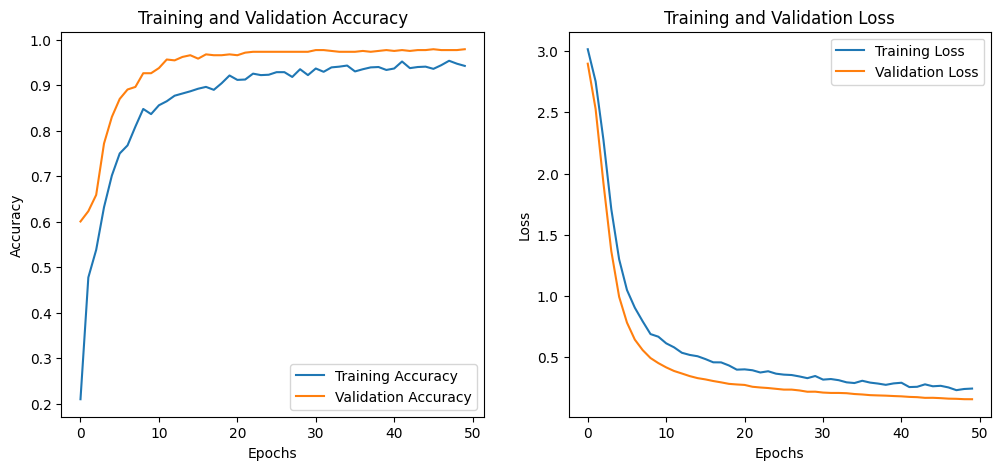

In [56]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

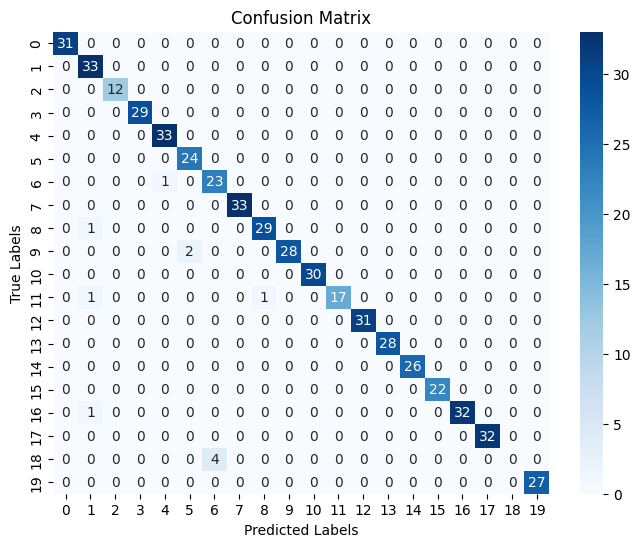

In [58]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, lstm_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

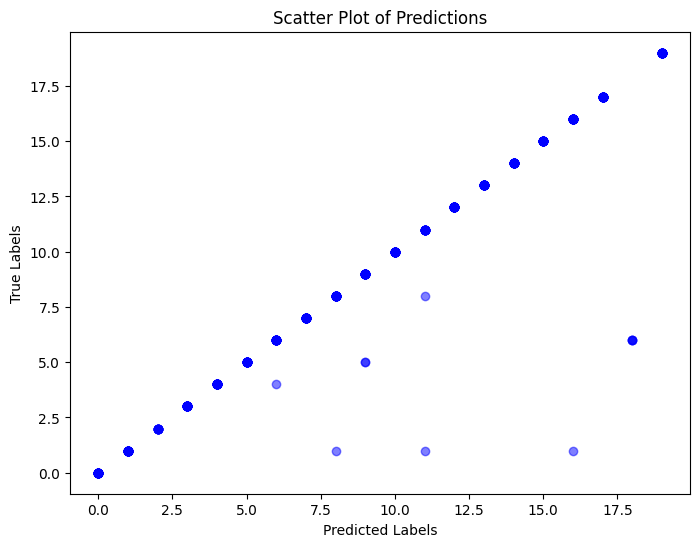

In [59]:
# Scatter plot of true vs. predicted labels
plt.figure(figsize=(8,6))
plt.scatter(y_test, lstm_pred, alpha=0.5, color='blue')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Scatter Plot of Predictions')
plt.show()

**MLP**

In [ ]:
# MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(150, 100), activation='relu', solver='adam', max_iter=700, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

In [ ]:
# Get predictions for the MLP model
mlp_pred = mlp_model.predict(X_test)  # Remove np.argmax and axis=1

# Compute Accuracy
mlp_accuracy = accuracy_score(y_test, mlp_pred)

# Compute Mean Absolute Error (MAE)
mlp_mae = mean_absolute_error(y_test, mlp_pred)

# Compute Mean Squared Error (MSE)
mlp_mse = mean_squared_error(y_test, mlp_pred)

# Print the results
print(f"MLP Model Accuracy: {mlp_accuracy * 100:.2f}%")
print(f"MLP Model Mean Absolute Error (MAE): {mlp_mae:.4f}")
print(f"MLP Model Mean Squared Error (MSE): {mlp_mse:.4f}")

MLP Model Accuracy: 98.68%
MLP Model Mean Absolute Error (MAE): 0.1092
MLP Model Mean Squared Error (MSE): 1.1563


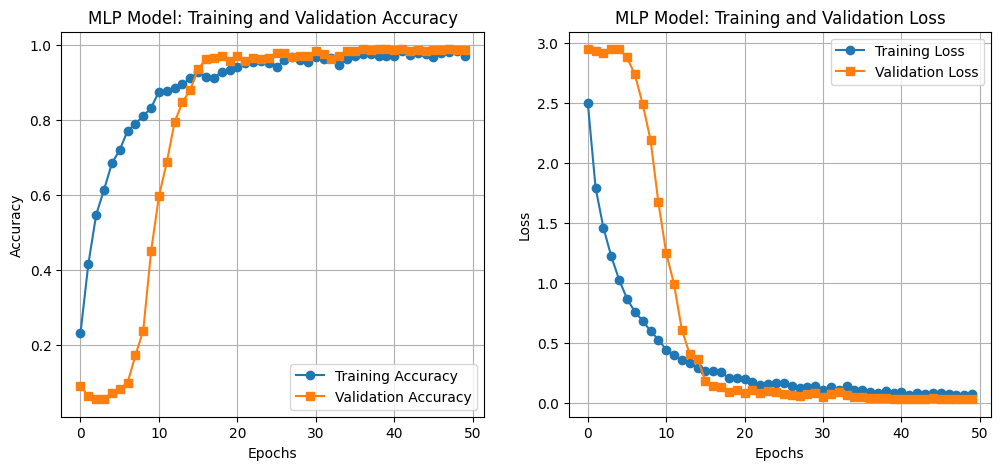

In [ ]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP Model: Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Model: Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()

**Left Plot (Accuracy):** Training (blue) and validation (orange) accuracies rise quickly in the first 10–15 epochs. Both reach nearly 100% by 20 epochs and stabilize, showing no major overfitting.  

**Right Plot (Loss):** Training (blue) and validation (orange) losses drop sharply from ~3.0 in the first 15 epochs and stabilize after 20 epochs, indicating convergence and good generalization.

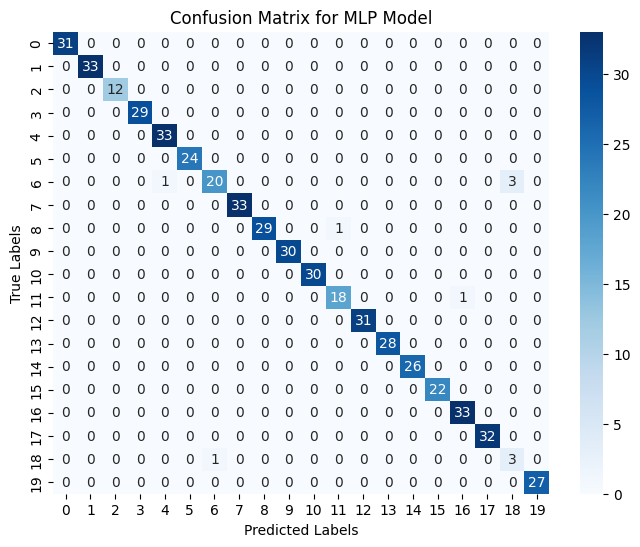

In [ ]:
# Generate predictions
mlp_pred = mlp_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, mlp_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP Model')
plt.show()

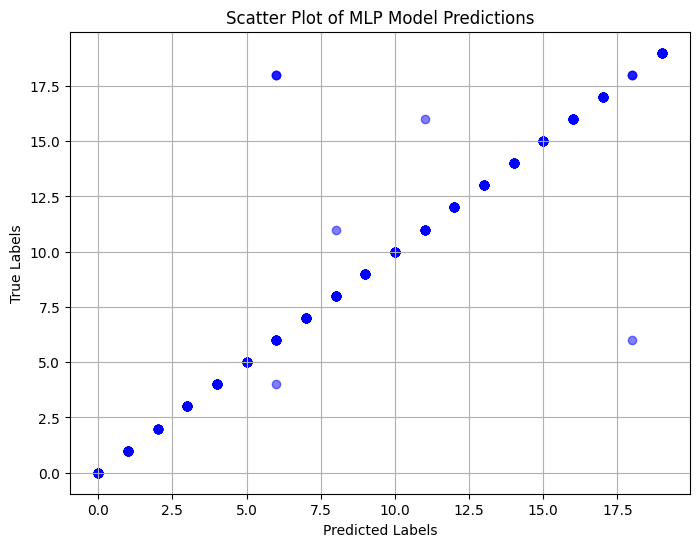

In [ ]:
# Scatter plot of true vs. predicted labels
plt.figure(figsize=(8,6))
plt.scatter(y_test, mlp_pred, alpha=0.5, color='blue')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Scatter Plot of MLP Model Predictions')
plt.grid(True)
plt.show()

**ANN**

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the ANN model
ann_model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='linear')  # Changed to linear activation
])

# Compile the model
ann_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Train the model
ann_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Make predictions
ann_pred = np.argmax(ann_model.predict(X_test), axis=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0647 - loss: 8.0634 - val_accuracy: 0.1017 - val_loss: 4.9313
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0738 - loss: 6.9203 - val_accuracy: 0.1205 - val_loss: 3.9686
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0804 - loss: 5.9349 - val_accuracy: 0.1563 - val_loss: 3.6103
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1040 - loss: 5.0086 - val_accuracy: 0.2090 - val_loss: 3.5592
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1117 - loss: 5.1090 - val_accuracy: 0.3013 - val_loss: 3.3123
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1080 - loss: 4.8296 - val_accuracy: 0.3804 - val_loss: 3.0982
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1383 - loss: 4.2728 - val_accuracy: 0.4105 - val_loss: 2.8078
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1456 - loss: 4.0146 - val_accuracy: 0.4049 - val_loss: 2.6

In [81]:
# Generate predictions for the ANN model
ann_pred = np.argmax(ann_model.predict(X_test), axis=1)  # Assuming softmax activation in the last layer

# Compute Accuracy
ann_accuracy = accuracy_score(y_test, ann_pred)

# Compute Mean Absolute Error (MAE)
ann_mae = mean_absolute_error(y_test, ann_pred)

# Compute Mean Squared Error (MSE)
ann_mse = mean_squared_error(y_test, ann_pred)

# Print the results
print(f"ANN Model Accuracy: {ann_accuracy * 100:.2f}%")
print(f"ANN Model Mean Absolute Error (MAE): {ann_mae:.4f}")
print(f"ANN Model Mean Squared Error (MSE): {ann_mse:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ANN Model Accuracy: 80.04%
ANN Model Mean Absolute Error (MAE): 1.4200
ANN Model Mean Squared Error (MSE): 12.8927


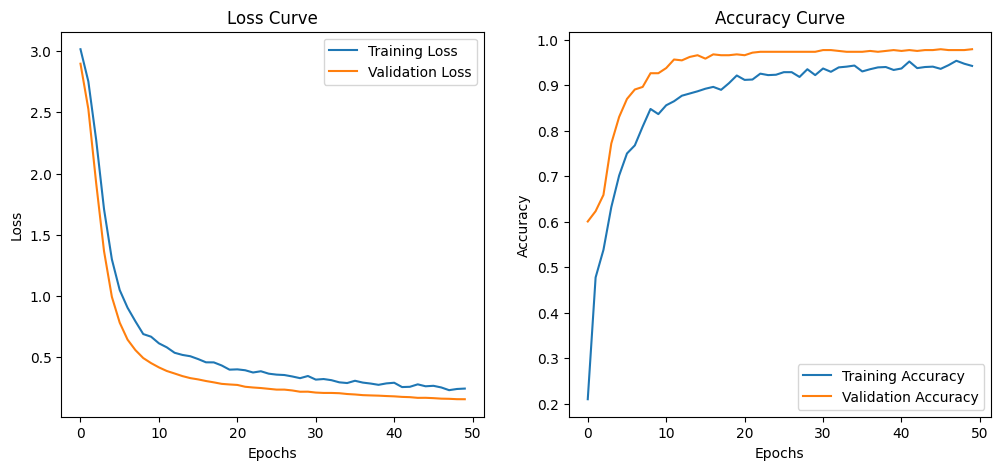

In [80]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy Curve (for classification problems)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

plt.show()

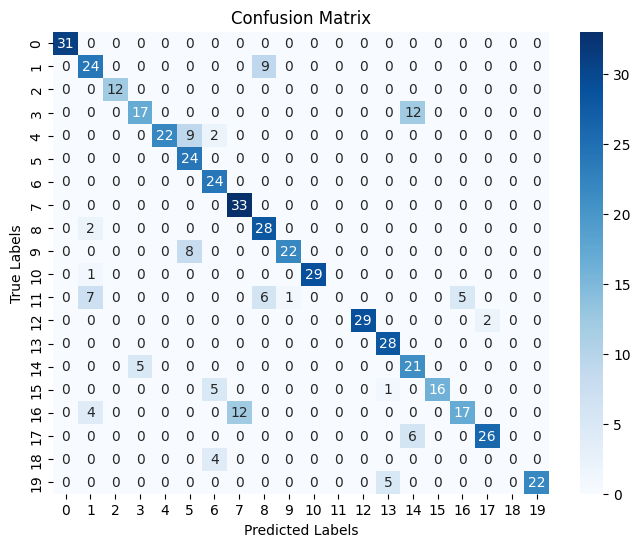

In [82]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, ann_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

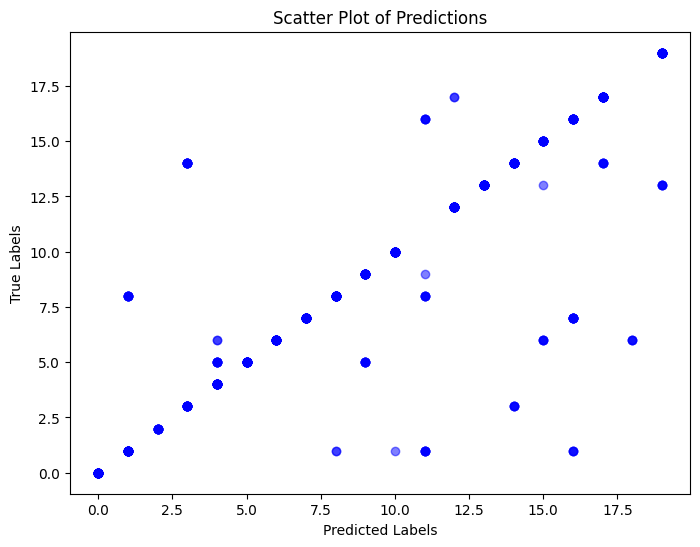

In [83]:
# Scatter plot of true vs. predicted labels
plt.figure(figsize=(8,6))
plt.scatter(y_test, ann_pred, alpha=0.5, color='blue')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Scatter Plot of Predictions')
plt.show()

# **Performance of Evaluation**

|Metrics|LSTM|ANN|MLP|
|----|----|----|----|
|Accuracy |97.93%|80.04%|98.68%|
|Mean Absolute Error|0.1751|1.4200|0.1092|
|Mean Squared Error|1.8738|12.8927|1.1563|


**The result of my cording part does not match with the result of the research paper. I think there is no evidence that what preprocessing techniques were used in the research paper. So I checked missing values, checked outliers, used data cleaning and remove duplicates and lable encoder techniques. Also I think hyperparameters and model architecture is difference so there is no note in the research paper about what hyperparameters were used. Also there is no note in the paper about epochs, batch size and hardware setup. The results have changed due to these reasons.**